In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import gseapy as gp
import decoupler as dc
import matplotlib.pyplot as plt
import time

In [4]:
sc.set_figure_params(dpi=100, facecolor=None, color_map="seismic", frameon=False, vector_friendly=True, transparent=True)
sc.settings._vector_friendly = False

In [5]:
# set working directory
project_dir = "/Users/cenkcelik/Cenk_scoring/"
working_dir = project_dir + ""
os.chdir(working_dir)

# set figure directory
figure_dir = working_dir + "figures/"

# processed data directory
processed_data = working_dir + "processed_data/"

In [6]:
# import a local package
import sys
sys.path.append("/Users/cenkcelik/Documents/GitHub/EnrichMap/")
import enrichmap as em

In [7]:
adata = sq.datasets.visium_hne_adata()

In [8]:
adata.layers["counts"] = adata.raw.X.copy()

In [9]:
adata.X = adata.layers["counts"].copy()

In [10]:
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["log1p_norm"] = adata.X.copy()

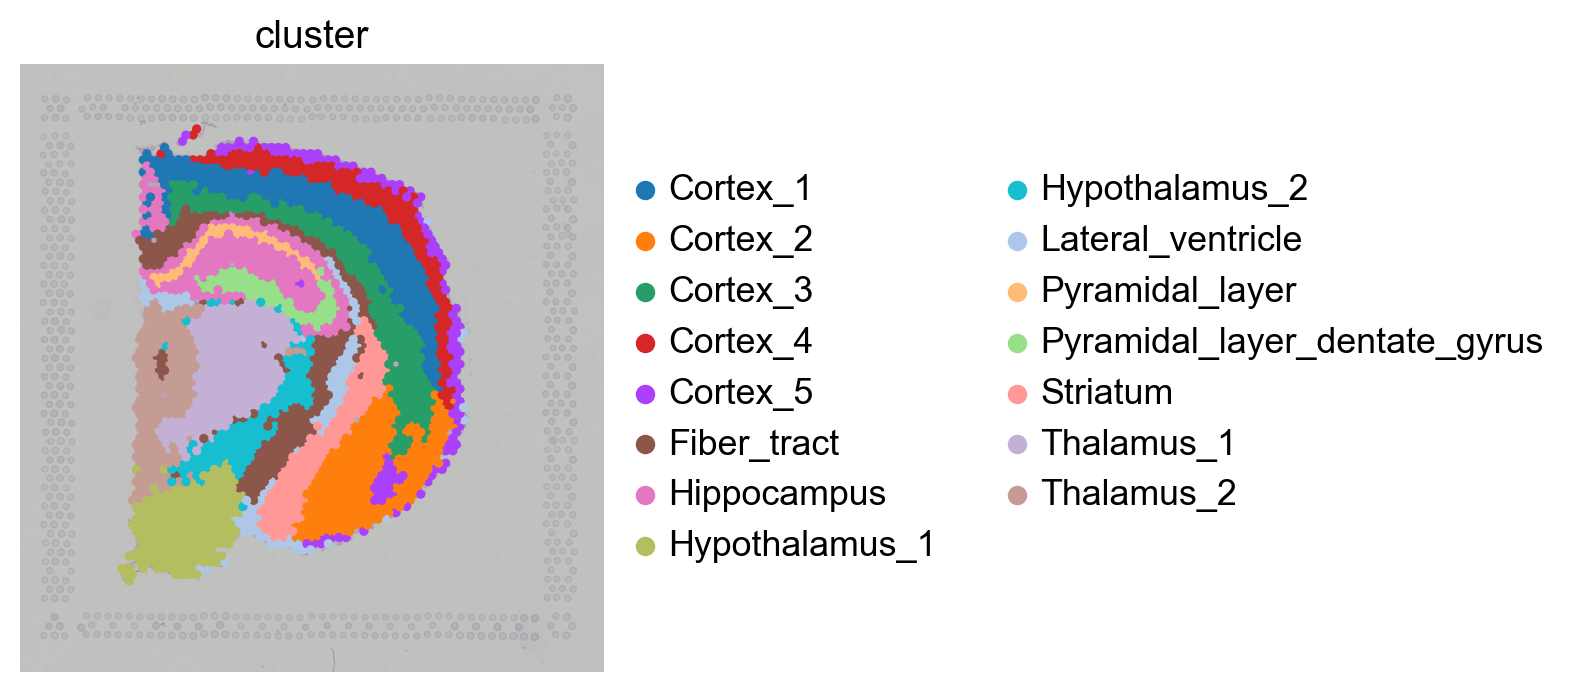

In [11]:
sq.pl.spatial_scatter(adata, color="cluster", size=2, img_alpha=0.5)

In [12]:
sc.tl.rank_genes_groups(adata, groupby="cluster", method="wilcoxon", layer="log1p_norm", use_raw=False)
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.5, min_fold_change=2, max_out_group_fraction=0.5)

In [13]:
gene_set_2 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:2].tolist()
gene_set_5 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:5].tolist()
gene_set_10 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:10].tolist()
gene_set_20 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:20].tolist()
gene_set_50 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:50].tolist()
gene_set_100 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:100].tolist()
gene_set_200 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:200].tolist()
gene_set_500 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:500].tolist()

In [14]:
gene_sets = [gene_set_2, gene_set_5, gene_set_10, gene_set_20, gene_set_50, gene_set_100, gene_set_200, gene_set_500]
methods = ["enrichmap", "aucell", "scanpy_score", "ssgsea", "gsva", "z_score"]
timings = {method: [] for method in methods}

In [15]:
for gene_set in gene_sets:
    # enrichmap
    t1 = time.time()
    adata_temp = adata.copy()
    em.tl.score(
        adata_temp,
        gene_set=gene_set,
        smoothing=True,
        correct_spatial_covariates=True,
        batch_key=None
    )
    t2 = time.time()
    timings["enrichmap"].append(t2 - t1)

    # Prepare signatures for AUCell, ssGSEA, GSVA
    signatures_dict = {
        "Pyramidal_layer": gene_set
    }
    signatures = pd.DataFrame(
        [(key, gene) for key, genes in signatures_dict.items() for gene in genes],
        columns=["geneset", "genesymbol"]
    )

    # AUCell
    t1 = time.time()
    adata_temp = adata.copy()
    dc.run_aucell(
        adata_temp,
        net=signatures,
        source="geneset",
        target="genesymbol",
        seed=0,
        min_n=2,
        verbose=False,
        use_raw=False
    )
    acts = dc.get_acts(adata_temp, obsm_key="aucell_estimate")
    adata_temp.obs["aucell_score"] = acts.obsm["aucell_estimate"]["Pyramidal_layer"]
    t2 = time.time()
    timings["aucell"].append(t2 - t1)

    # Scanpy score_genes
    t1 = time.time()
    adata_temp = adata.copy()
    sc.tl.score_genes(adata_temp, gene_set, score_name="scanpy_score", use_raw=False)
    t2 = time.time()
    timings["scanpy_score"].append(t2 - t1)

    # Prepare gene expression DataFrame
    X_dense = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
    gene_expr = pd.DataFrame(X_dense.T, index=adata.var_names, columns=adata.obs_names)
    gene_expr.index = gene_expr.index.str.upper()
    signatures_dict_upper = {k: [g.upper() for g in v] for k, v in signatures_dict.items()}

    # ssGSEA
    t1 = time.time()
    ssgsea = gp.ssgsea(
        data=gene_expr,
        gene_sets=signatures_dict_upper,
        outdir=None,
        sample_norm_method="rank",
        no_plot=True,
        min_size=2
    )
    nes = ssgsea.res2d.pivot(index="Term", columns="Name", values="NES")
    adata_temp.obs["ssgsea_score"] = nes.loc["Pyramidal_layer"].T.astype(float).reindex(adata.obs_names)
    t2 = time.time()
    timings["ssgsea"].append(t2 - t1)

    # GSVA
    t1 = time.time()
    gsva = gp.gsva(
        data=gene_expr,
        gene_sets=signatures_dict_upper,
        outdir=None,
        min_size=2
    )
    es = gsva.res2d.pivot(index="Term", columns="Name", values="ES")
    adata_temp.obs["gsva_score"] = es.loc["Pyramidal_layer"].T.astype(float).reindex(adata.obs_names)
    t2 = time.time()
    timings["gsva"].append(t2 - t1)

    # Z-score
    gene_set_upper = signatures_dict_upper["Pyramidal_layer"]
    t1 = time.time()
    z_score = gene_expr.loc[gene_set_upper].sum(axis=0) / np.sqrt(len(gene_set_upper))
    adata_temp.obs["z_score"] = z_score
    t2 = time.time()
    timings["z_score"].append(t2 - t1)

Scoring signatures: 100%|██████████| 1/1 [00:21<00:00, 21.64s/it]


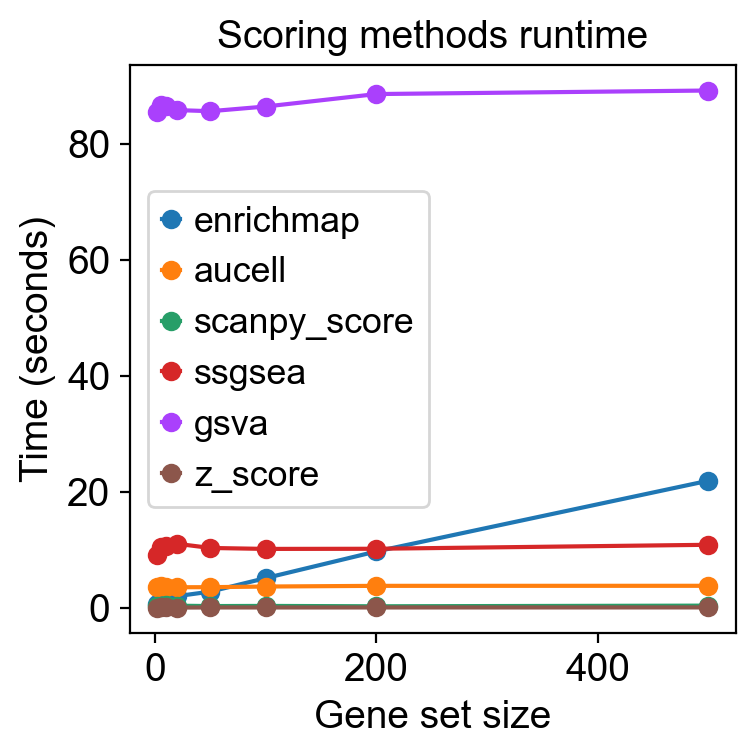

In [16]:
# Plot
fig, ax = plt.subplots(figsize=(4, 4))

for method in methods:
    ax.plot(
        [len(gs) for gs in gene_sets],
        timings[method],
        marker='o',
        label=method
    )

ax.set_xlabel("Gene set size")
ax.set_ylabel("Time (seconds)")
ax.set_title("Scoring methods runtime")
ax.legend()
ax.grid(False)
plt.tight_layout()
plt.savefig(figure_dir + "scoring_methods_runtime_all.pdf", dpi=300, bbox_inches="tight")
plt.show()

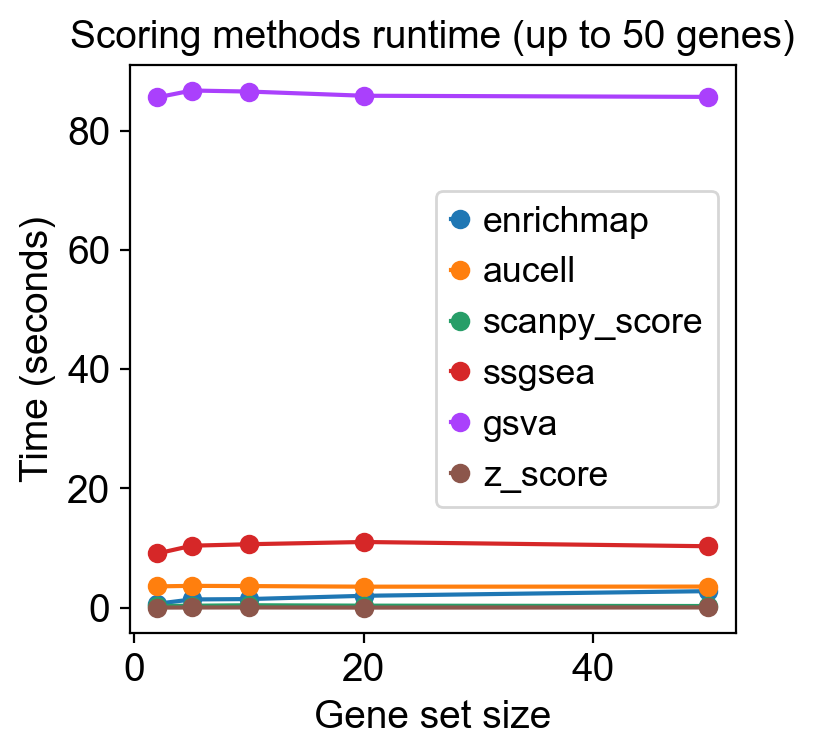

In [17]:
# plot only up to 50 genes
fig, ax = plt.subplots(figsize=(4, 4))
for method in methods:
    ax.plot(
        [len(gs) for gs in gene_sets[:5]],
        timings[method][:5],
        marker='o',
        label=method
    )
ax.set_xlabel("Gene set size")
ax.set_ylabel("Time (seconds)")
ax.set_title("Scoring methods runtime (up to 50 genes)")
ax.legend()
ax.grid(False)
plt.tight_layout()
plt.savefig(figure_dir + "scoring_methods_runtime_50_genes.pdf", dpi=300, bbox_inches="tight")
plt.show()